# P03_01_Univar_LSTM

In [1]:
section_fig_main_title = 'P03_01_Univar_LSTM_'

In [2]:
import os, sys
import requests
from urllib.parse import urljoin, urlparse
from bs4 import BeautifulSoup as bs
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from pandas.plotting import lag_plot

In [3]:
from pandas.plotting import autocorrelation_plot


In [8]:
import tensorflow as tf
tf.__version__

import tensorflow as tf
from tensorflow import keras

import gif
from tqdm import tqdm


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [9]:
from sklearn import metrics
import statsmodels.api as sm

## Read Data 

Using the original data without any feature engineering.

In [40]:
csv_path = "../Data/Data_ICME_Edited_Decoded_out_P02_03.csv"
df = pd.read_csv(csv_path, parse_dates=True, infer_datetime_format=True)

In [41]:
df.head(2)

,ICME Plasma/Field Start Y/M/D (UT) (b),ICME Plasma/Field End Y/M/D (UT) (b),BDE? (e),Qual. (g),dV (km/s) (h),V_ICME (km/s) (i),V_max (km/s) (j),B (nT) (k),MC? (l),Dst (nT) (m),Normalized_time_interval
0,1996-05-27 15:00:00,1996-05-29 03:00:00,1,2,1,370,400,9,3,117,1.375000
1,1996-07-01 18:00:00,1996-07-02 11:00:00,1,4,44,360,370,11,3,78,0.583333


drop ICME start and end columns and make start ICME as index.

In [42]:

df['ICME Plasma/Field Start Y/M/D (UT) (b)'] = pd.to_datetime(df['ICME Plasma/Field Start Y/M/D (UT) (b)'])
df['ICME Plasma/Field End Y/M/D (UT) (b)'] = pd.to_datetime(df['ICME Plasma/Field End Y/M/D (UT) (b)'])

In [43]:
df.index = df['ICME Plasma/Field Start Y/M/D (UT) (b)']
df = df.drop(columns=['ICME Plasma/Field Start Y/M/D (UT) (b)'])
df = df.drop(columns=['ICME Plasma/Field End Y/M/D (UT) (b)'])
# df.head()

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 493 entries, 1996-05-27 15:00:00 to 2021-05-12 15:00:00
Data columns (total 9 columns):
BDE? (e)                    493 non-null int64
Qual. (g)                   493 non-null int64
dV (km/s) (h)               493 non-null int64
V_ICME (km/s) (i)           493 non-null int64
V_max (km/s) (j)            493 non-null int64
B (nT) (k)                  493 non-null int64
MC? (l)                     493 non-null int64
Dst (nT) (m)                493 non-null int64
Normalized_time_interval    493 non-null float64
dtypes: float64(1), int64(8)
memory usage: 38.5 KB


## Goal

The goal is to predict the ICME speed taking the last 60 timestamps into account.

In [45]:
plt.rcParams["figure.figsize"] = (8, 8)


In [52]:
ICME_speed = pd.Series(df['V_ICME (km/s) (i)'])
ICME_speed.head()

ICME Plasma/Field Start Y/M/D (UT) (b)
1996-05-27 15:00:00    370
1996-07-01 18:00:00    360
1996-08-07 12:00:00    350
1996-12-23 17:00:00    360
1997-01-10 04:00:00    450
Name: V_ICME (km/s) (i), dtype: int64

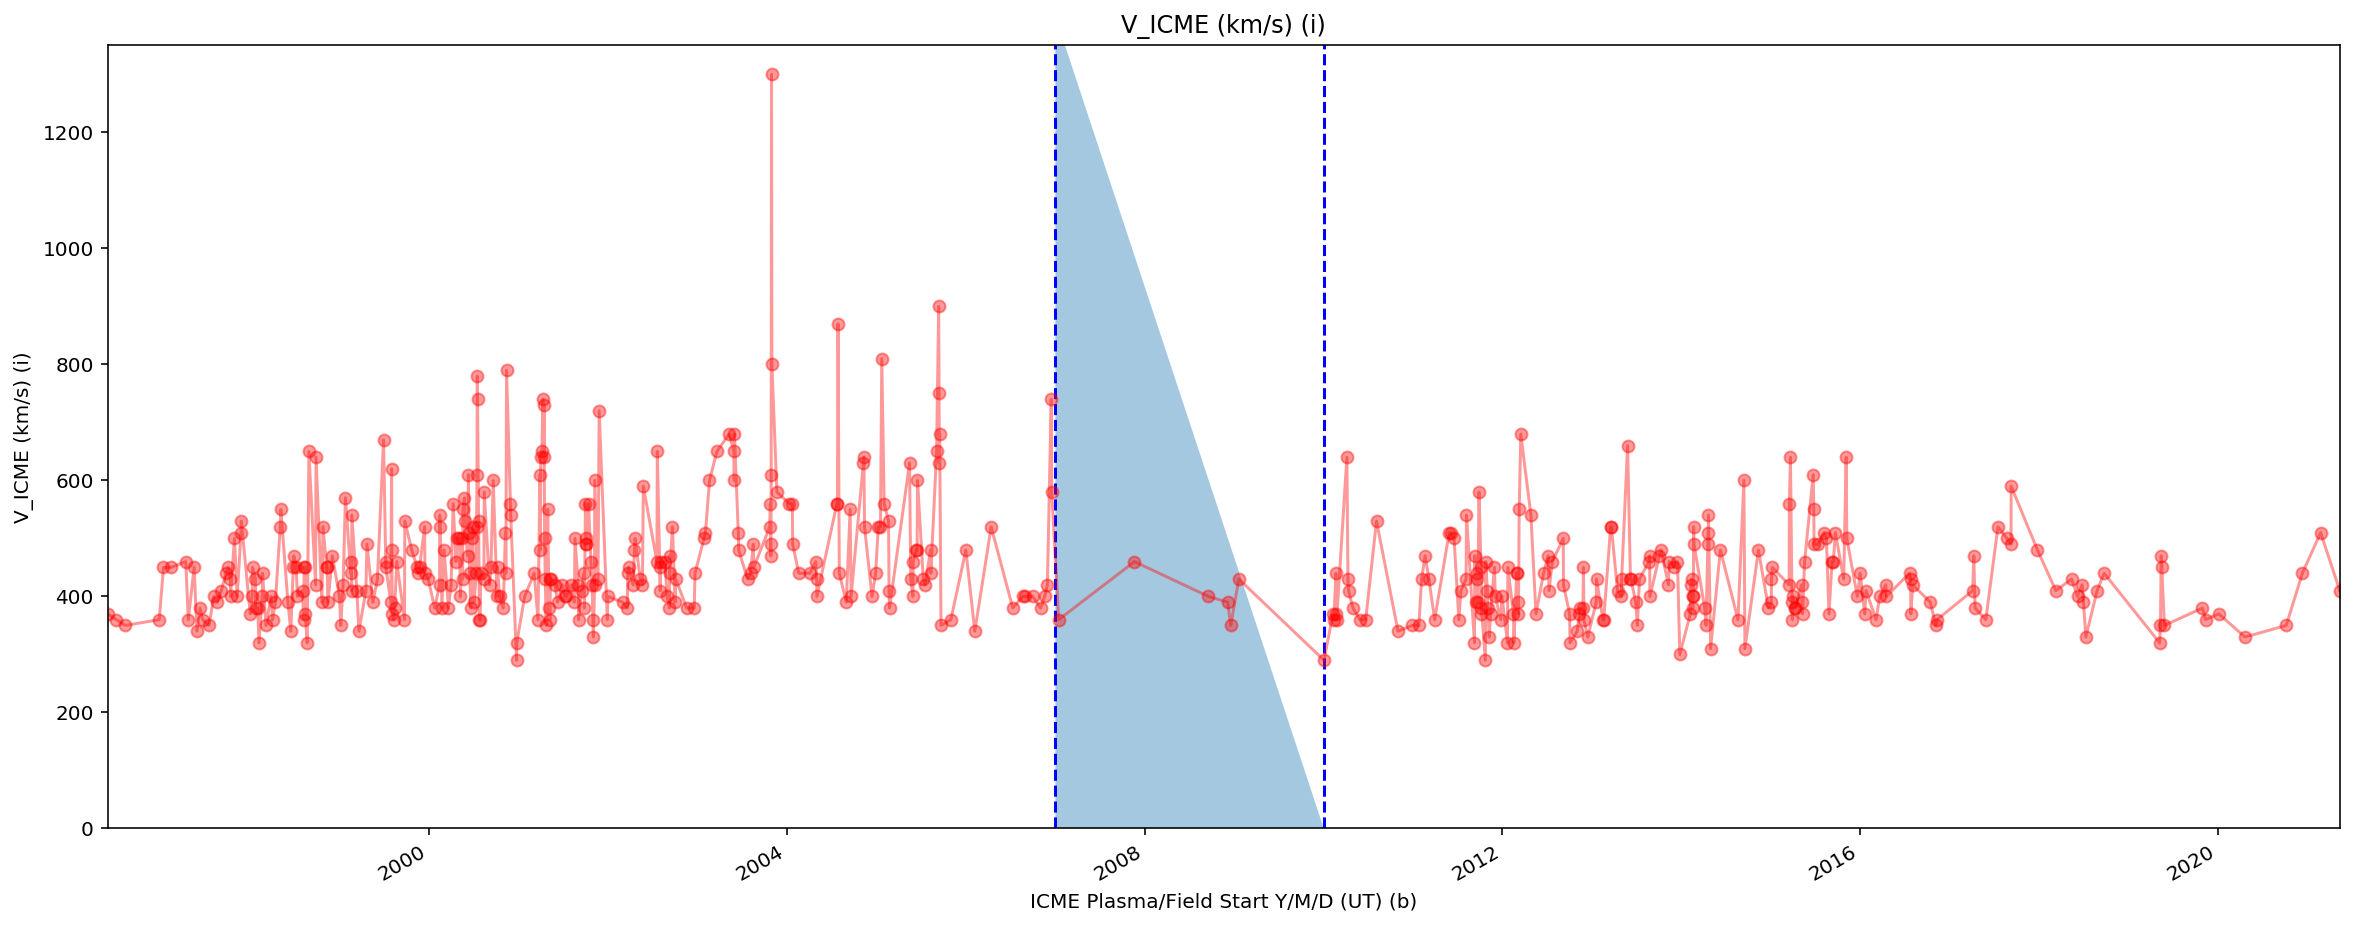

In [106]:
plt.figure(figsize=(20,8))
ICME_speed.plot(style="ro-", alpha=0.4)


plt.title("V_ICME (km/s) (i)")
plt.ylabel("V_ICME (km/s) (i)")
plt.ylim(0,)


plt.vlines('2007', 0, 1400, colors='b', linestyles='--')
plt.vlines('2010', 0, 1400, colors='b', linestyles='--')


x = ['2007', '2007', '2010', '2010']
y = [0, 1400, 0, 1400]

plt.fill_between(x, y, alpha=0.4)



# plt.savefig("../Figures/" + section_fig_main_title +"plt2.png")

plt.show()

## Set data parameters


In [57]:
len(ICME_speed)

493

In [58]:
# use first 20000 timestamps for training 
size_of_training = 300

In [59]:
ICME_speed[0:1].index[0]


Timestamp('1996-05-27 15:00:00')

In [60]:
# set the start of training row date
train_start = ICME_speed[0:1].index[0]
train_start = str(train_start)
train_start

'1996-05-27 15:00:00'

In [61]:
# set the end of training row date
train_end = ICME_speed[(size_of_training-1):size_of_training].index[0]
train_end = str(train_end)
train_end

'2008-12-17 03:00:00'

In [62]:
# use last 60 time stamps for prediction
lags = 60

In [72]:
# plt.figure(figsize=(20,8))
# ICME_speed.plot(style="ro-", alpha=0.4)
# ICME_speed.diff().plot(style="k^-", alpha=0.4)



# plt.title("V_ICME (km/s) (i)")
# plt.ylabel("V_ICME (km/s) (i)")
# # plt.ylim(0,)

# # plt.savefig("../Figures/" + section_fig_main_title +"plt2.png")

# plt.show()

I seperate the next 720 time stamps for prediction however I need to include the number of lags nessaccary to the test data set. keep that in mind I need to seperate the data from main data set from the row 20000 to 20760, However I have to subtract the 20000 from 60 (lag time stamps) which later I would need for predicting the first row of data set.

Let's find the date of the first row of test dat set.